# Ion Molmer Sorenson sims

quantsim library courtesy of Chriss Knapp 2018

testing/rejig by Sam Hile 2018/19

In [1]:
import iomoso
from iomoso.Core import Parameter, Hamiltonian
from iomoso.Scan import TimeScan, ParamScan

import qutip as qu
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Some utilities (to be integrated maybe?):

In [2]:
def plot_H_size(H,log=False):
    if log:
        H = qu.Qobj(np.choose(np.sign(H.full()).astype(int)+1, [-log10(H.full()),0*(H.full()),log10(H.full())] ),dims=H.dims)
    fig,axe = qu.hinton(H)
    fig.set_size_inches(4,4)
    axe.set_xticklabels(axe.get_xticklabels(), rotation=80, fontsize=8);
    axe.set_yticklabels(axe.get_yticklabels(), rotation=10, fontsize=8);
    #return H

### Notes
* all frequencies are angular, give as 2\*pi\*[[Hz]]
* core concept is that we model N ions, in a phonon cavity with M modes, and under irradiation with K excitation frequencies (allocated on a per ion basis, with free choice of power and detuning)

First, set up all the parameters we might want for various terms

In [3]:
#zeeSO = [-2*pi*19.2e3, -2*pi*30.05e3]       # Second order Zeeman shift for each ion
B_0 = array([7.86e-4,9.83e-4])  # B-field at ion positions (Tesla)
Z_2 = 2*pi*31080e6                    # 2nd order Zeeman splitting coefficient for Yb (Hz per Tesla^2)
delta_Z = -B_0*B_0*Z_2             # Second order Zeeman shift for each ion
print(f'Field: {B_0} T')
print('Zeeman:',delta_Z/2/pi,'Hz')

eta = 0.0042                     # Lamb-Dicke coupling parameter
nu = 2*pi*925e3                  # Motional secular frequency of trap
print('Coupling:',eta,'.')
print('Secular freq:',nu/2/pi,'Hz')

Omega_D = 2*pi*36e3              # Dressed qubit Rabi frequency (effective power)
Omega_RF = sqrt(2)*Omega_D       # RF Rabi frequency (actual power - single transition)
Omega_UW1 = 2*pi*20e3       # MW Rabi frequency (actual power - single transition)
Omega_UW2 = 2*pi*21e3       # MW Rabi frequency (other transition) different to suppress J-coupling
print('Rabi Dressed:',Omega_D/2/pi,'Hz')
print('Rabi RF:',Omega_RF/2/pi,'Hz')
print('Rabi MW1:',Omega_UW1/2/pi,'Hz')
print('Rabi MW2:',Omega_UW2/2/pi,'Hz')

Delta = 2*eta*Omega_D            # MS gate detuning parameter 
t_MS = 2*pi/Delta                # MS gate time (one loop)
print('Detuning:',Delta/2/pi,'Hz')

# calculate light (AC-Stark) shift on each ion, caused by off-resonant RF excitation
# from equation 6.13 in Joe Randall thesis
Delta_LS = (3/4)*Omega_RF**2*delta_Z/nu**2       
print('Light shift:',Delta_LS/2/pi,'Hz')   

Field: [ 0.000786  0.000983] T
Zeeman: [-19201.09968 -30032.26212] Hz
Coupling: 0.0042 .
Secular freq: 925000.0000000001 Hz
Rabi Dressed: 36000.0 Hz
Rabi RF: 50911.6882454 Hz
Rabi MW1: 20000.0 Hz
Rabi MW2: 21000.0 Hz
Detuning: 302.40000000000003 Hz
Light shift: [-43.62534729 -68.23400153] Hz


## 1.0 uncoupled driving / dressing

In [4]:
H = Hamiltonian(nions = 2, nfock = 6, gradient = True, ZeeSO = delta_Z, eta1 = eta, trapfreq = nu)

# dressing fields
H.addUwPlus(ion = 1, amp = Omega_UW1, det = 0)
H.addUwMinus(ion = 1, amp = Omega_UW1, det = 0)
#H.addUwPlus(ion = 2, amp = Omega_UW2, det = 0)
#H.addUwMinus(ion = 2, amp = Omega_UW2, det = 0)

# RF (1Q gate) fields
H.addRfPlus(ion = 1, amp = Omega_RF, det = 1*Delta_LS[0], includeMinus=False)

# RF (2Q gate) fields
#H.addRfPlus(ion = 1, amp = Omega_RF, det = - nu - Delta + Delta_LS[0], includeMinus=True)
#H.addRfPlus(ion = 1, amp = Omega_RF, det = nu + Delta + Delta_LS[0] , includeMinus=True)
#H.addRfPlus(ion = 2, amp = Omega_RF, det = - nu - Delta + Delta_LS[1] , includeMinus=True)
#H.addRfPlus(ion = 2, amp = Omega_RF, det = nu + Delta + Delta_LS[1] , includeMinus=True)

psi0 = H.initial_state(['0p', '0p'], 0)     # initial state - |0'> = 0p
times = np.linspace(0, 0.2*t_MS, 1000)     # integrate to gate time +20%
sim = TimeScan(H, times, psi0)

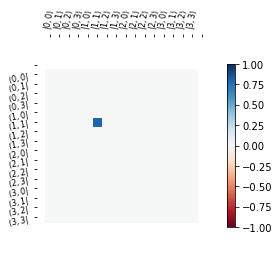

In [5]:
plot_H_size(qu.ptrace(qu.ket2dm(psi0),[0,1]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


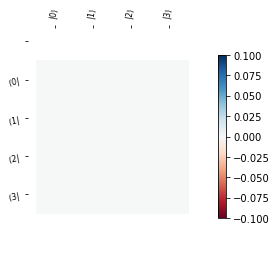

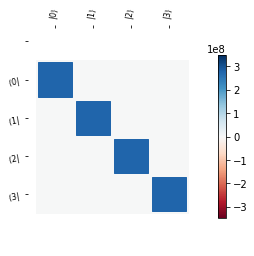

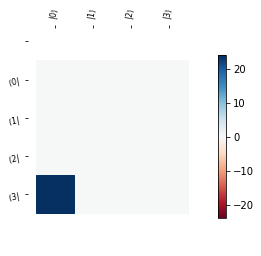

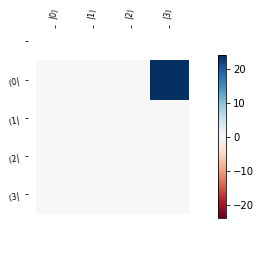

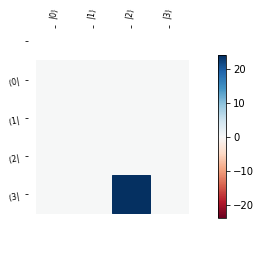

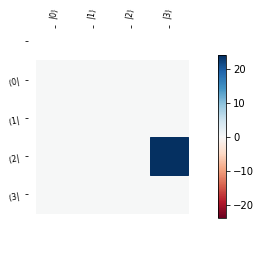

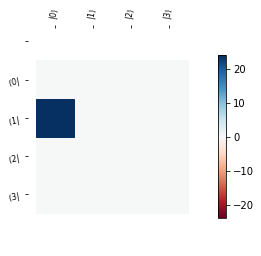

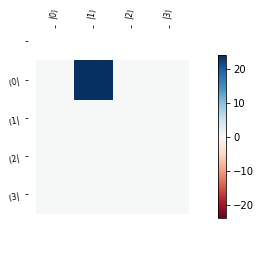

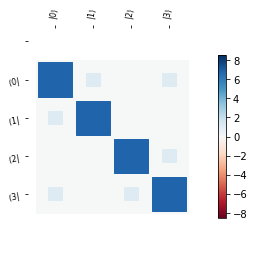

In [24]:
AA = [qu.ptrace(A['op'],[0]) for A in H.Hterms]
#Asum = np.sum(AA)
[plot_H_size(A,log=False) for A in AA]
Asum = np.sum(AA)
plot_H_size(Asum,log=True)

In [63]:
H.Hterms

[{'op': Quantum object: dims = [[4, 4, 6], [4, 4, 6]], shape = (96, 96), type = oper, isherm = True
  Qobj data =
  [[     0.          48820.34983679      0.         ...,      0.              0.
         0.        ]
   [ 48820.34983679      0.          69042.40085898 ...,      0.              0.
         0.        ]
   [     0.          69042.40085898      0.         ...,      0.              0.
         0.        ]
   ..., 
   [     0.              0.              0.         ...,      0.              0.
         0.        ]
   [     0.              0.              0.         ...,      0.              0.
         0.        ]
   [     0.              0.              0.         ...,      0.              0.
         0.        ]], 'timedep': False},
 {'op': Quantum object: dims = [[4, 4, 6], [4, 4, 6]], shape = (96, 96), type = oper, isherm = True
  Qobj data =
  [[        0.                 0.                 0.         ...,         0.
            0.                 0.        ]
   [      

In [6]:
sim.run()

10.0%. Run time:   0.44s. Est. time left: 00:00:00:03
20.0%. Run time:   0.95s. Est. time left: 00:00:00:03
30.0%. Run time:   1.49s. Est. time left: 00:00:00:03
40.0%. Run time:   2.02s. Est. time left: 00:00:00:03
50.0%. Run time:   2.55s. Est. time left: 00:00:00:02
60.0%. Run time:   3.13s. Est. time left: 00:00:00:02
70.0%. Run time:   3.67s. Est. time left: 00:00:00:01
80.0%. Run time:   4.21s. Est. time left: 00:00:00:01
90.0%. Run time:   4.74s. Est. time left: 00:00:00:00
Total run time:   5.26s


## 1.1 ion 1 state

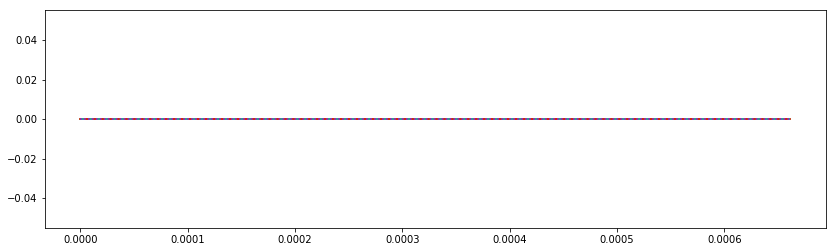

In [7]:
plt.figure(figsize=(14,4))
plt.plot(times, sim.getPopulations(['0', '0']), 'g')
plt.plot(times, sim.getPopulations(['0p', '0']), 'r')
plt.plot(times, sim.getPopulations(['-1','0']), 'c--')
plt.plot(times, sim.getPopulations(['+1','0']), 'm:')

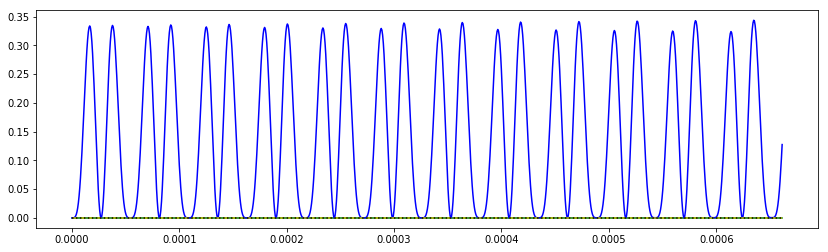

In [8]:
plt.figure(figsize=(14,4))
plt.plot(times, sim.getPopulations(['0', '0']), 'g')
plt.plot(times, sim.getPopulations(['0', '0p']), 'b')
plt.plot(times, sim.getPopulations(['0', '-1']), 'y--')
plt.plot(times, sim.getPopulations(['0', '+1']), 'k:')

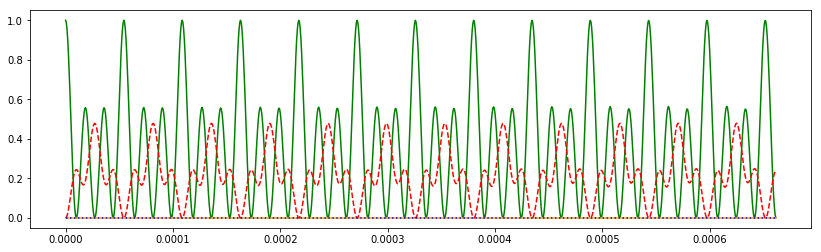

In [9]:
plt.figure(figsize=(14,4))
plt.plot(times, sim.getPopulations(['0p', '0p']), 'g')
plt.plot(times, sim.getPopulations(['d', 'd']), 'orange')
plt.plot(times, sim.getPopulations(['d', '0p']), 'r--')
plt.plot(times, sim.getPopulations(['0p', 'd']), 'b:')

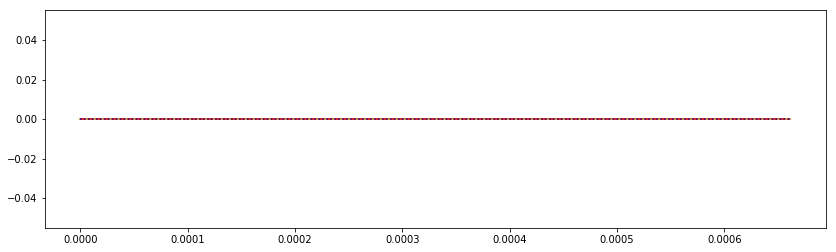

In [10]:
plt.figure(figsize=(14,4))
plt.plot(times, sim.getPopulations(['0', '0']), 'g')
plt.plot(times, sim.getPopulations(['u', 'u']), 'orange')
plt.plot(times, sim.getPopulations(['u', '0']), 'r--')
plt.plot(times, sim.getPopulations(['0', 'u']), 'b:')

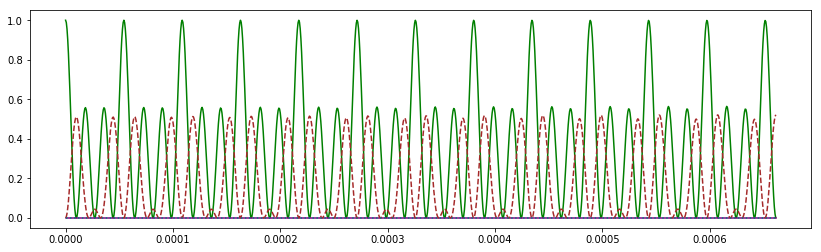

In [11]:
plt.figure(figsize=(14,4))
plt.plot(times, sim.getPopulations(['0p', '0p']), 'g')
plt.plot(times, sim.getPopulations(['D', 'D']), 'purple')
plt.plot(times, sim.getPopulations(['D', '0p']), 'brown', linestyle='--')
plt.plot(times, sim.getPopulations(['0p', 'D']), 'teal', linestyle=':')

In [121]:
p0p0p = sim.getPopulations(['0p', '0p'])
pDD = sim.getPopulations(['D', 'D'])
p0D = sim.getPopulations(['0p','D'])
pD0 = sim.getPopulations(['D','0p'])

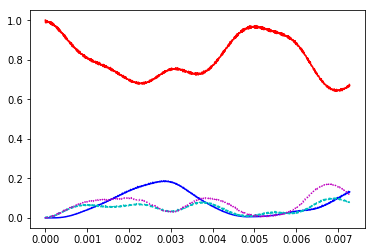

In [122]:
plt.plot(times, p0p0p, 'r')
plt.plot(times, pDD, 'b')
plt.plot(times, p0D, 'c--')
plt.plot(times, pD0, 'm:')

In [103]:
plt.show() #N=8

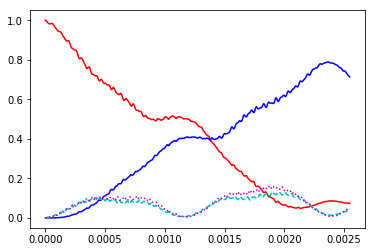

In [74]:
plt.show() #N=4

In [8]:
H?

In [248]:
qu.Options?